In [569]:
import pandas as pd
import numpy as np
import seaborn as sns

from typing import List, Tuple

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

import scipy.stats as stats

### Question 1

#### a.)

Choosing to take part in a survey is a form of non-response bias which occurs when respondents do not answer the survey because of some confounder, in this case we are looking at a *voluntary* form of non-response bias because the participants ability to *choose* whether or not to answer the questions. The confoudner responsible for *why* is unknown to us, the people doing the measuring and can range from sending the survey at the wrong time for a simple non-response to asking too many vague questions or somehow intimidating the repondents with the question

#### b.)

The result of receiving such inaccurate responses is the bias trap, where we as interviewers receive a result deviating from the truth this is especially dangerous if the bias is systematic. For example, in the context of non-response bias, we never received answers from people booking holidays in the south of Spain, this can be because it is a senior friendly location and potentially caused by the over-representation of seniors not answering the survey. This can mislead us into thinking our questions are ill-formulated when we were potentially asking the relatives who booked for the customers instead of the customers themselves. This can lead to:
- Ill-informed information communicated to the business which can lead to sub-optimal strategic decisions down the line
- Failure of subsequent surveys in the case of a multiple-measured experiment which can ruin future experiments
- Unreliable performance reviews, for example business thinks a product is doing less well than expected when in fact we were mislead by the review (especially if the only people responding are the unhappy ones, a common occurance)
- Generating poor quality data to feed to ML experiments which will drive other data scientists mad and cost us more compute for stratified sampling, data augmentation and more experimental runs
- Money: Inconclusive research is never fun to communicate to business

#### c.)

For this, one would send survey questions again, if it does not work or simply infeasible because of time constraints then we need to resort to *post-survey adjustments*

In [425]:
def insert_sys_nans(df: pd.DataFrame, 
                    prob: float)->pd.DataFrame:
    """
    Helper function to systematically select indices to replace with nans based on an age mask
    """
    mask = df[df["age_bucket"] == "64+"].index
    idx = np.random.choice(len(mask), size=int(len(mask) * prob))
    
    
    df.iloc[idx, -1] = 0  #responded set to no for all indices+
    col_list = [0, 1]

    for row in idx:
        col = np.random.choice(col_list)
        df.iloc[row, col] = np.nan
        
    return df

In [570]:
def insert_rand_nans(df: pd.DataFrame, 
                     n: int)->List[Tuple[int]]:
    """
    Helper function to randomly select indices to replace with nans
    """
    rows, cols = df.shape
    idx = [(row, col) for row in range(rows) for col in range(cols)]
    #make systematic:

    rand_indices = np.random.choice(len(idx), size=n, replace=False)
    
    return [idx[i] for i in rand_indices]

In [427]:
def generate_behavioral_data(survey_data: pd.DataFrame,
                            seed: int=2012) -> pd.DataFrame:
    
    """
    Generate behavioral data and merge to the main survey dataset
    """
    
    np.random.seed(seed)
    n_samples = survey_data.shape[0]
    
    behavioral_data = pd.DataFrame({
        "cust_id" : survey_data.index,  #to simulate inner join
        "no_dead_clicks" : np.random.choice(np.arange(1, 30), size=n_samples),
        "checkout_time" : np.random.choice(np.arange(45, 300), size=n_samples),
        "home_button_clicks" : np.random.choice(np.arange(0, 5), 
                                        size=n_samples),
    })
    
    
    return survey_data.merge(behavioral_data, 
                             left_on=survey_data.index, 
                             right_on="cust_id", how="inner")

In [539]:
def generate_dummies(n_samples: int,
                    prob_nan_systematic : float,
                    seed: int=2012,
                    probs: List[float]=0.0,
                    prob_nan : float=0.2,
                    deviation : bool=False) -> pd.DataFrame:
    """
    Helper function to generate random survey data
    """
    np.random.seed(seed)
    data = pd.DataFrame({
        "ease_of_use" : np.random.choice(np.arange(1, 6), p=probs, size=n_samples),
        "information_availability" : np.random.choice(np.arange(1, 6), p=np.random.permutation(probs), 
                                                      size=n_samples),
        "age_bucket" : np.random.choice(["0-15", "15-64", "64+"], p=[0.25, 0.35, 0.4], 
                                        size=n_samples),
    })
    
    # add nans randomly with helper
    idx_list = insert_rand_nans(data, np.ceil(prob_nan * n_samples).astype(int))
    data["responded"] = np.ones(data.shape[0])
    #helper for systematic nans:
    data = insert_sys_nans(data, prob_nan_systematic)
    
    for row, col in idx_list:
        data.iloc[row, col] = np.nan
        data.iloc[row, -1] = 0
        
    if deviation:
        data["ease_of_use"] = data["ease_of_use"] + data["ease_of_use"].std() * 0.5
        data["ease_of_use"] = data["ease_of_use"].clip(1, 5)
        
    return data

In [580]:
probs=[0.1, 0.1, 0.15, 0.25, 0.4]
prob = 0.2
prob_nan_systematic = 0.3

In [581]:
data = generate_dummies(n_samples=2000, prob_nan_systematic=prob_nan_systematic,
                        probs=probs, prob_nan=prob)
joined_data = generate_behavioral_data(pd.get_dummies(data))

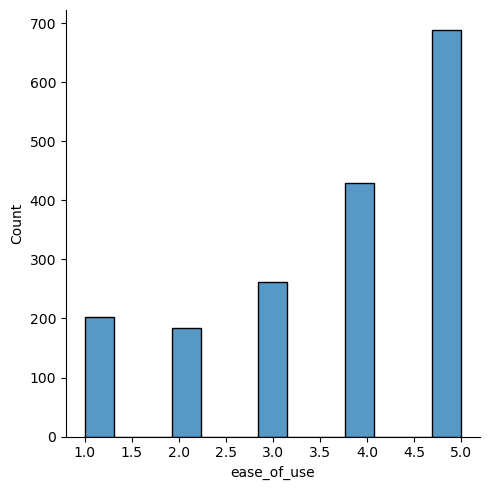

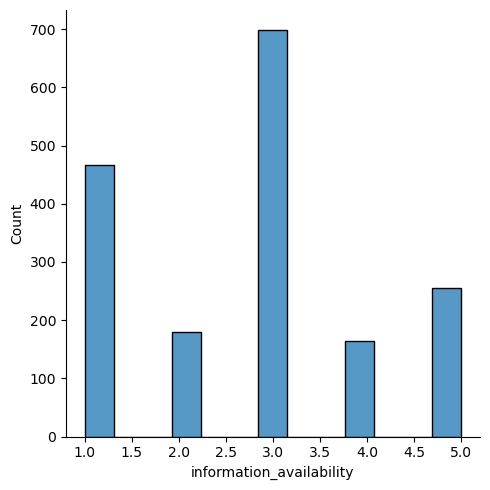

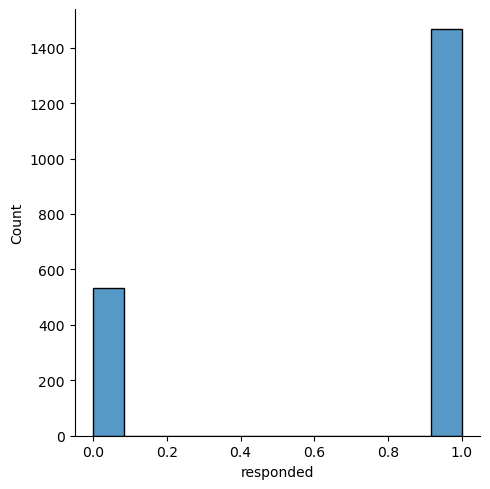

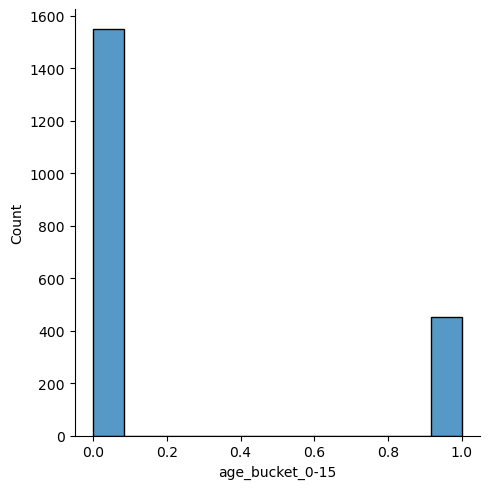

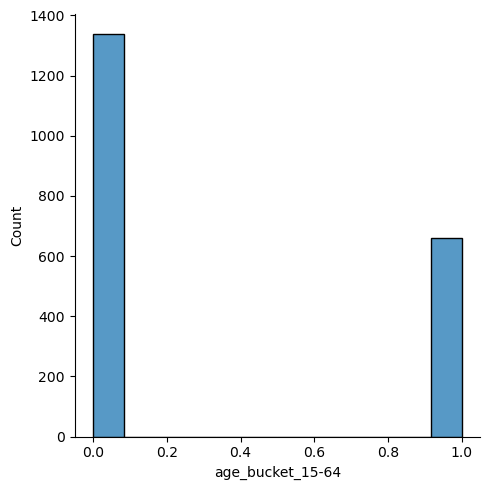

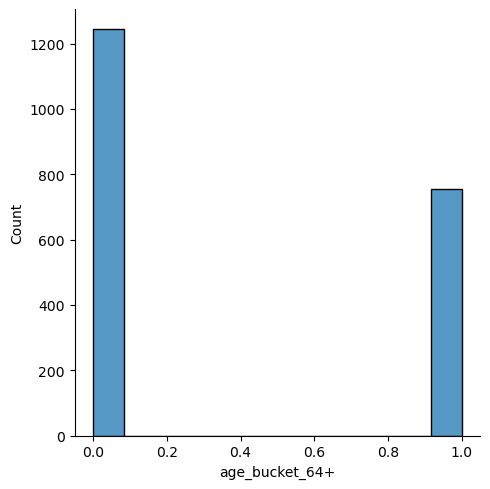

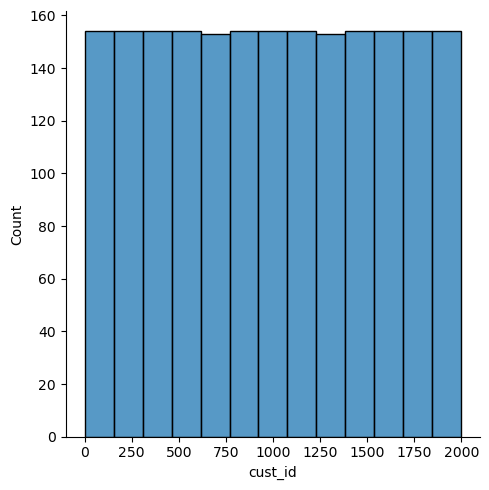

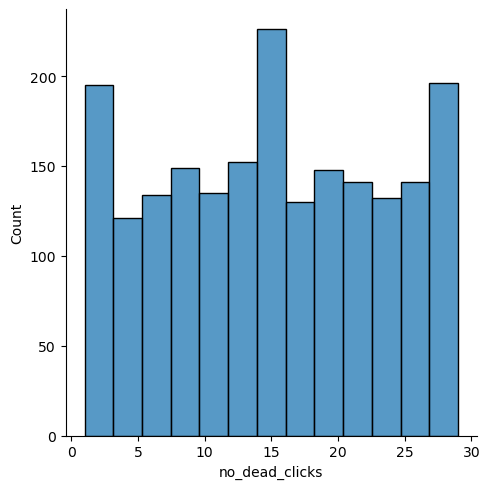

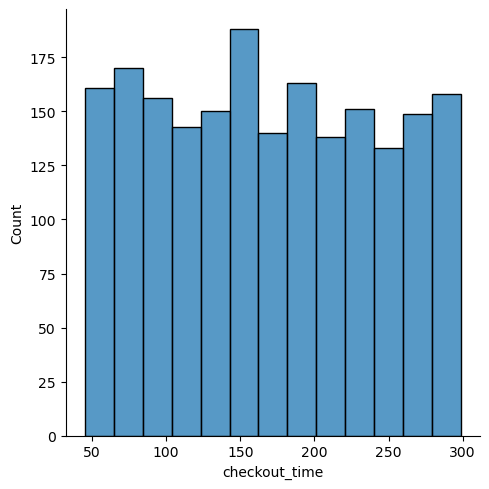

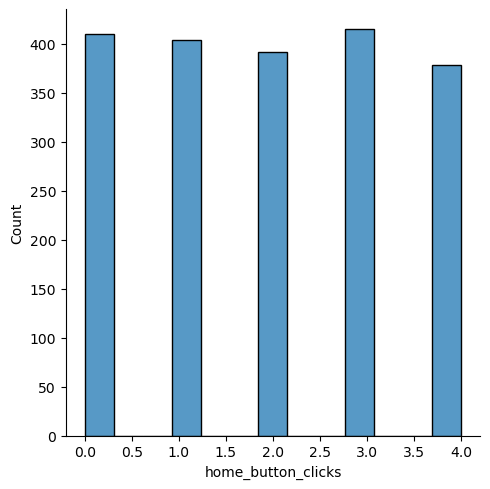

In [585]:
for i in joined_data.columns:
    sns.displot(joined_data[i])

Some examples of post-survey adjustments:
- Robust imputation techniques (MAD), but we should careful when using this as we suspect one group to be overrepresented
- Weighting techniques:
    - Design weight: compensate for under or over-sampling (we might want to oversample younger people who responded for example)
    - Post-stratification weights are more relevant here as we have older over-representing our survey. We should calculate the proportion of the survey + proportion of population attending these vacation spots and multiply each value with its respective weight where: weight = population proportion/completed survey proportion

In [418]:
imp_mean = SimpleImputer(missing_values=np.nan, 
                         strategy="median")
imp_mean.fit(data.drop("age_bucket", axis=1))\
    .transform(data.drop("age_bucket", axis=1))

array([[4., 3., 0.],
       [4., 5., 1.],
       [4., 3., 0.],
       ...,
       [5., 3., 1.],
       [5., 1., 1.],
       [5., 2., 1.]])

#### d.)

By user data I assume you mean cookie-collected information, for this, I generated data about dead clicks which we aim at minimizing, time spent while on the checkout page (which I assume we also aim at minimizing), number of times the tab has been exited, number of times the customer returned to the home page. Depending on the question we want to answer, this can either be seen as a way to further understand certain strata (seniors in this case) through clustering or by understanding the relationships between the behavioral data and survey by viewing the score as an outcome variable.

<Axes: >

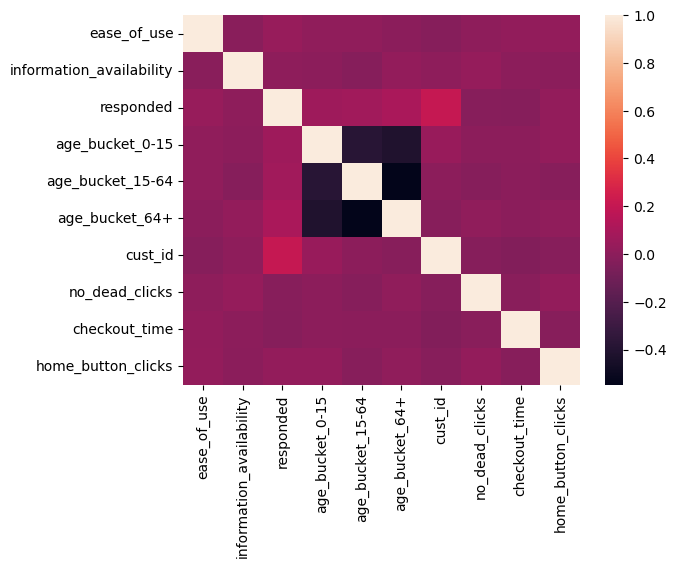

In [444]:
sns.heatmap(joined_data.corr())

### Question 2

#### a.)

In [540]:
# To make things simple, the data from the survey is duplicated with some added deviation and nans
data_pre = generate_dummies(n_samples=2000, prob_nan_systematic=prob_nan_systematic,
                        probs=probs, prob_nan=prob)
data_post = generate_dummies(n_samples=2000, prob_nan_systematic=prob_nan_systematic,
                        probs=probs, prob_nan=prob * 1.5, deviation=True)

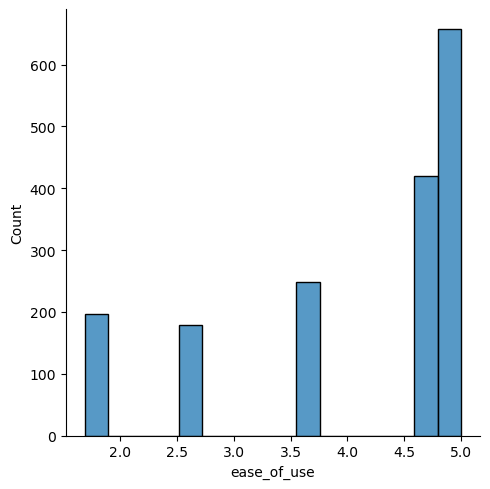

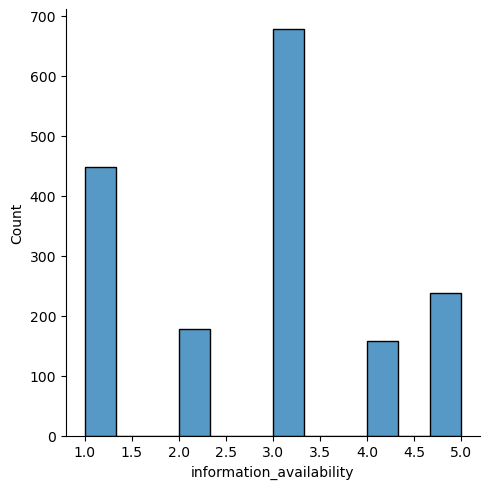

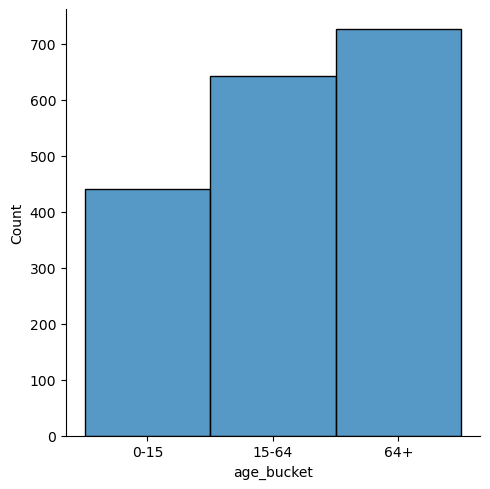

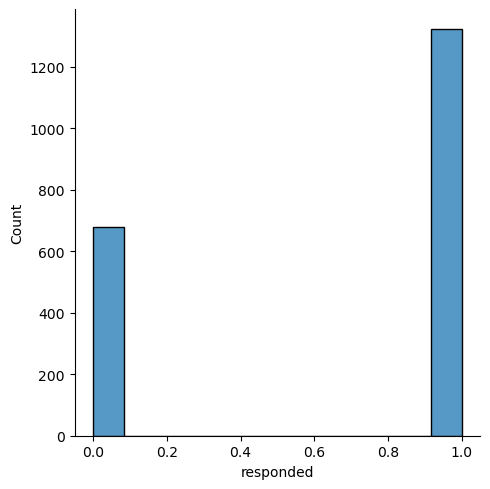

In [583]:
for i in data_post.columns:
    sns.displot(data_post[i])

Visual analysis:

Text(0.5, 1.0, 'Visualized Boxplots for both touchpoints')

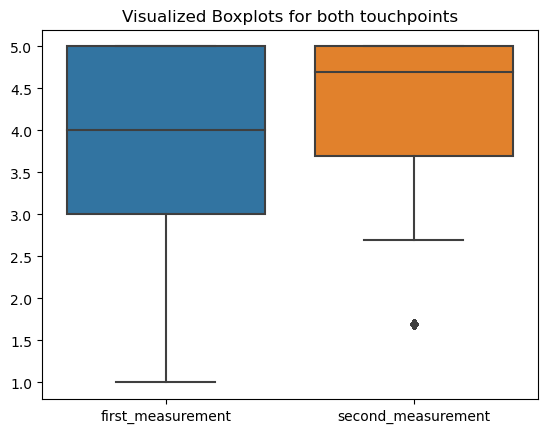

In [558]:
df_viz = pd.DataFrame({
    "first_measurement" : data_pre["ease_of_use"],
    "second_measurement" : data_post["ease_of_use"]

})
sns.boxplot(df_viz).set_title("Visualized Boxplots for both touchpoints (with outliers)")

Comparing means in this context means comparing the same group in a repeated measurement setting. This calls for a paired t-test because of the dependence of both groups. Since we assume observations are independent from one another in our simualted data, we now need to check for the normality of the difference between the second and intial measurement.

<Axes: xlabel='ease_of_use', ylabel='Count'>

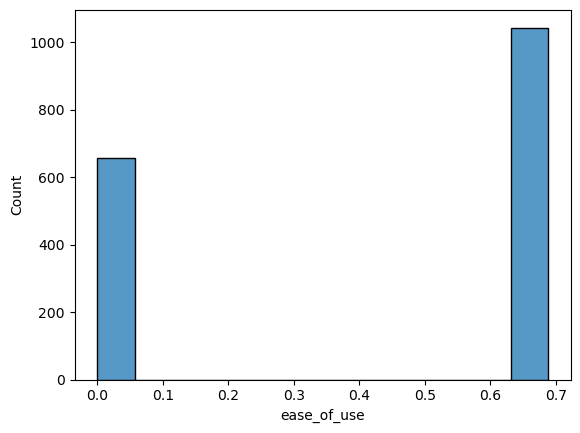

In [543]:
sns.histplot(data_post["ease_of_use"] - data_pre["ease_of_use"])

In [579]:
# padding nans with median for simplicity and use the shapiro - Wilk test to confirm this 
stats.shapiro(data_post["ease_of_use"].fillna(data_post["ease_of_use"].median()) - 
              data_pre["ease_of_use"].fillna(data_pre["ease_of_use"].median()))

ShapiroResult(statistic=0.6258190870285034, pvalue=0.0)

In [562]:
stats.ttest_rel(data_pre["ease_of_use"].fillna(data_post["ease_of_use"].median()), 
                data_post["ease_of_use"].fillna(data_pre["ease_of_use"].median()))

TtestResult(statistic=-23.93224904322804, pvalue=1.6412711924782654e-111, df=1999)

The test indicates significance, which is to be expected since we purposefully made the results of the second measurement higher, we can then safely reject the null hypothesis $H_0$ and accept $H_1$ indicating a difference between the two means issued from both measurements

#### b.)

Limitations of this comparison are as follows:

- Potential risk of non-response in the second measurement
- Normally distirbuted difference required between both samples
- Outlier sensitivity
- Introduction of survivorship bias for the occurances where we have both measurements
- Introduction of self-selection bias and another entry point for non-response bias
- Introduction of response shift bias (understanding of our Likert scale changes in-between)
- We should take into account potential behavioral confounders when analyzing the data, confirming a booking is not the same "feeling" as when searching for the perfect hotel room, this could skew the score to the right for some users. 
    
 How to interpret:
- We could use non-parametric tests if differences are not normally distributed such as the    Wilcoxon Signed Rank Test for example
- We could Consider using bootstrapping methods + confidence intervals to avert some of the introduced biases with a second measurement

#### c.)

To check if the two touch points are comparable, we performed the wilcoxon signed rank test and verified that all three assumptions for the paired t-test hold:

- Independent observations (random sample)
- Randomly-distributed difference between groups
- The dependent variable should not contain any outliers

#### d.)

Potential limitations discussed in the question b can be resolved with the mentioned confidence intervals or bootstrapping methods. However for more robustness against confounders, we can look at propensity weighting techniques such as inverse propensity weighting (IPW) before performing the t-test by following the below steps:
- We pick a target variable related to our suspected confounder, in our case it is the age (predicting whether a user belongs to the 65+ bucket).
- We fit a logistic regression model to calculate the probability of a user belonging to the 65+ bucket based on those convenient behavioral features.
- We reweigh the data using the inverse of the probability

If IPW fails, we can explore other techniques such as causal graphs where we can build a directed acyclic graph (DAG) based on domain knowledge, behavioral data and expected confounders. Based on the DAG and its minimal adjustment set, we can explore additional deconfounding methods such as d-separation.